In [1]:
from Functions import spaced_colors_from_cmap, compute_metric_sensitivity, plot_histograms
import MetricMapping

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Access the mappings:
type_mapping = MetricMapping.type_mapping
name_mapping = MetricMapping.name_mapping

In [3]:
# resolution_index = {'DMC_10': 2}
resolutions = ['', '_DMC_10']

In [4]:
transformed_minmax_scaled = pd.read_csv("../Data/NotScaled_RawVsDMC.csv")

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [31]:
# del transformed_minmax_scaled['relative_amp_scaled']
# del transformed_minmax_scaled['relative_amp_scaled_DMC_10']

# del transformed_minmax_scaled['peak_mean_ratio_scaled']
# del transformed_minmax_scaled['peak_mean_ratio_scaled_DMC_10']

# del transformed_minmax_scaled['min_intensity']
# del transformed_minmax_scaled['min_intensity_DMC_10']

# del transformed_minmax_scaled['m1']
# del transformed_minmax_scaled['m1_DMC_10']

del transformed_minmax_scaled['m2']
del transformed_minmax_scaled['m2_DMC_10']

del transformed_minmax_scaled['m3']
del transformed_minmax_scaled['m3_DMC_10']

del transformed_minmax_scaled['m4']
del transformed_minmax_scaled['m4_DMC_10']

del transformed_minmax_scaled['m5']
del transformed_minmax_scaled['m5_DMC_10']

In [7]:
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in column_names if metric not in categorical_metrics]

metric_base_names = {col.replace(suffix, '') for col in transformed_minmax_scaled.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [36]:
summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics)
summary_df["type2"] = summary_df["metric"].map(type_mapping)

# Sort by type_2 and descending rank_corr
summary_df = summary_df.sort_values(
    by=["type2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type2" else -col))

In [19]:
# # Exclude Categorical
# filtered_df.fillna('Categorical', inplace=True)
df_intermittency = summary_df[summary_df["type2"] == "Intermittency"]
df_other = summary_df[(summary_df["type2"] != "Intermittency") & (summary_df["type"] != "categorical")]
df_categorical = summary_df[summary_df["type"] == "categorical"]

In [39]:
# filtered_metrics = [metric for metric, mtype in MetricMapping.type_mapping.items()
#     if mtype not in ('Intermittency', 'Categorical')]

# print(filtered_metrics)

In [11]:
type_color_map = {
    'Asymmetry': spaced_colors_from_cmap("Blues", add_grey=True),
    'Peakiness': spaced_colors_from_cmap("Reds", add_grey=True),
    'Concentration': spaced_colors_from_cmap("Greens", add_grey=True),
    'Intermittency': spaced_colors_from_cmap("Purples", add_grey=True),
    'Categorical': spaced_colors_from_cmap("Oranges", add_grey=True),}


In [41]:
def plot_histograms(ax, metric, transformed_minmax_scaled, type_mapping, name_mapping, resolutions, log_scale_metrics, separate_bin_metrics=[]):
    this_type = type_mapping[metric]
    color_map = type_color_map[this_type]
    use_shared_bins = metric not in separate_bin_metrics
    bin_count = 20

    # Shared bin logic
    if use_shared_bins:
        all_values = []
        for res in resolutions:
            col_name = f"{metric}{res}"
            if col_name in transformed_minmax_scaled.columns:
                vals = transformed_minmax_scaled[col_name].dropna()
                if metric in log_scale_metrics:
                    vals = vals[vals > 0]
                all_values.append(vals)
        if not all_values:
            return
        all_vals_concat = pd.concat(all_values)
        bins = np.linspace(all_vals_concat.min(), all_vals_concat.max(), bin_count + 1)

    # Per-resolution plotting
    for res in resolutions:
        col_name = f"{metric}{res}"
        if col_name not in transformed_minmax_scaled.columns:
            continue

        values = transformed_minmax_scaled[col_name].dropna()
        if metric in log_scale_metrics:
            values = values[values > 0]
        if values.empty:
            continue

        if use_shared_bins:
            bin_edges = bins
        else:
            if metric in log_scale_metrics:
                bin_edges = 20  # Let seaborn pick based on data, with log axis
                ax.set_xscale("log")

                # Cleaner log formatting
                def decimal_formatter(x, pos):
                    if x < 1:
                        return f"{x:.3f}".rstrip('0').rstrip('.')
                    else:
                        return f"{x:.0f}"
                ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
            else:
                bin_edges = 20  # Default seaborn behavior

        # Optional: adjust yscale if needed (your logic)
        if col_name == 'mean_intensity':
            ax.set_yscale("log")
        if col_name == 'mean_intensity_DMC_10':
            bin_edges = 1

        sns.histplot(
            values,
            bins=bin_edges,
            kde=False,
            ax=ax,
            color=color_map[resolutions.index(res)],
            label=res,
            element='step',
            stat='density',
            fill=True,
            alpha=0.5,
        )

    # Final formatting
    title = name_mapping.get(metric, metric)
    ax.set_title(title, fontsize=25, fontstyle="italic")
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(True)


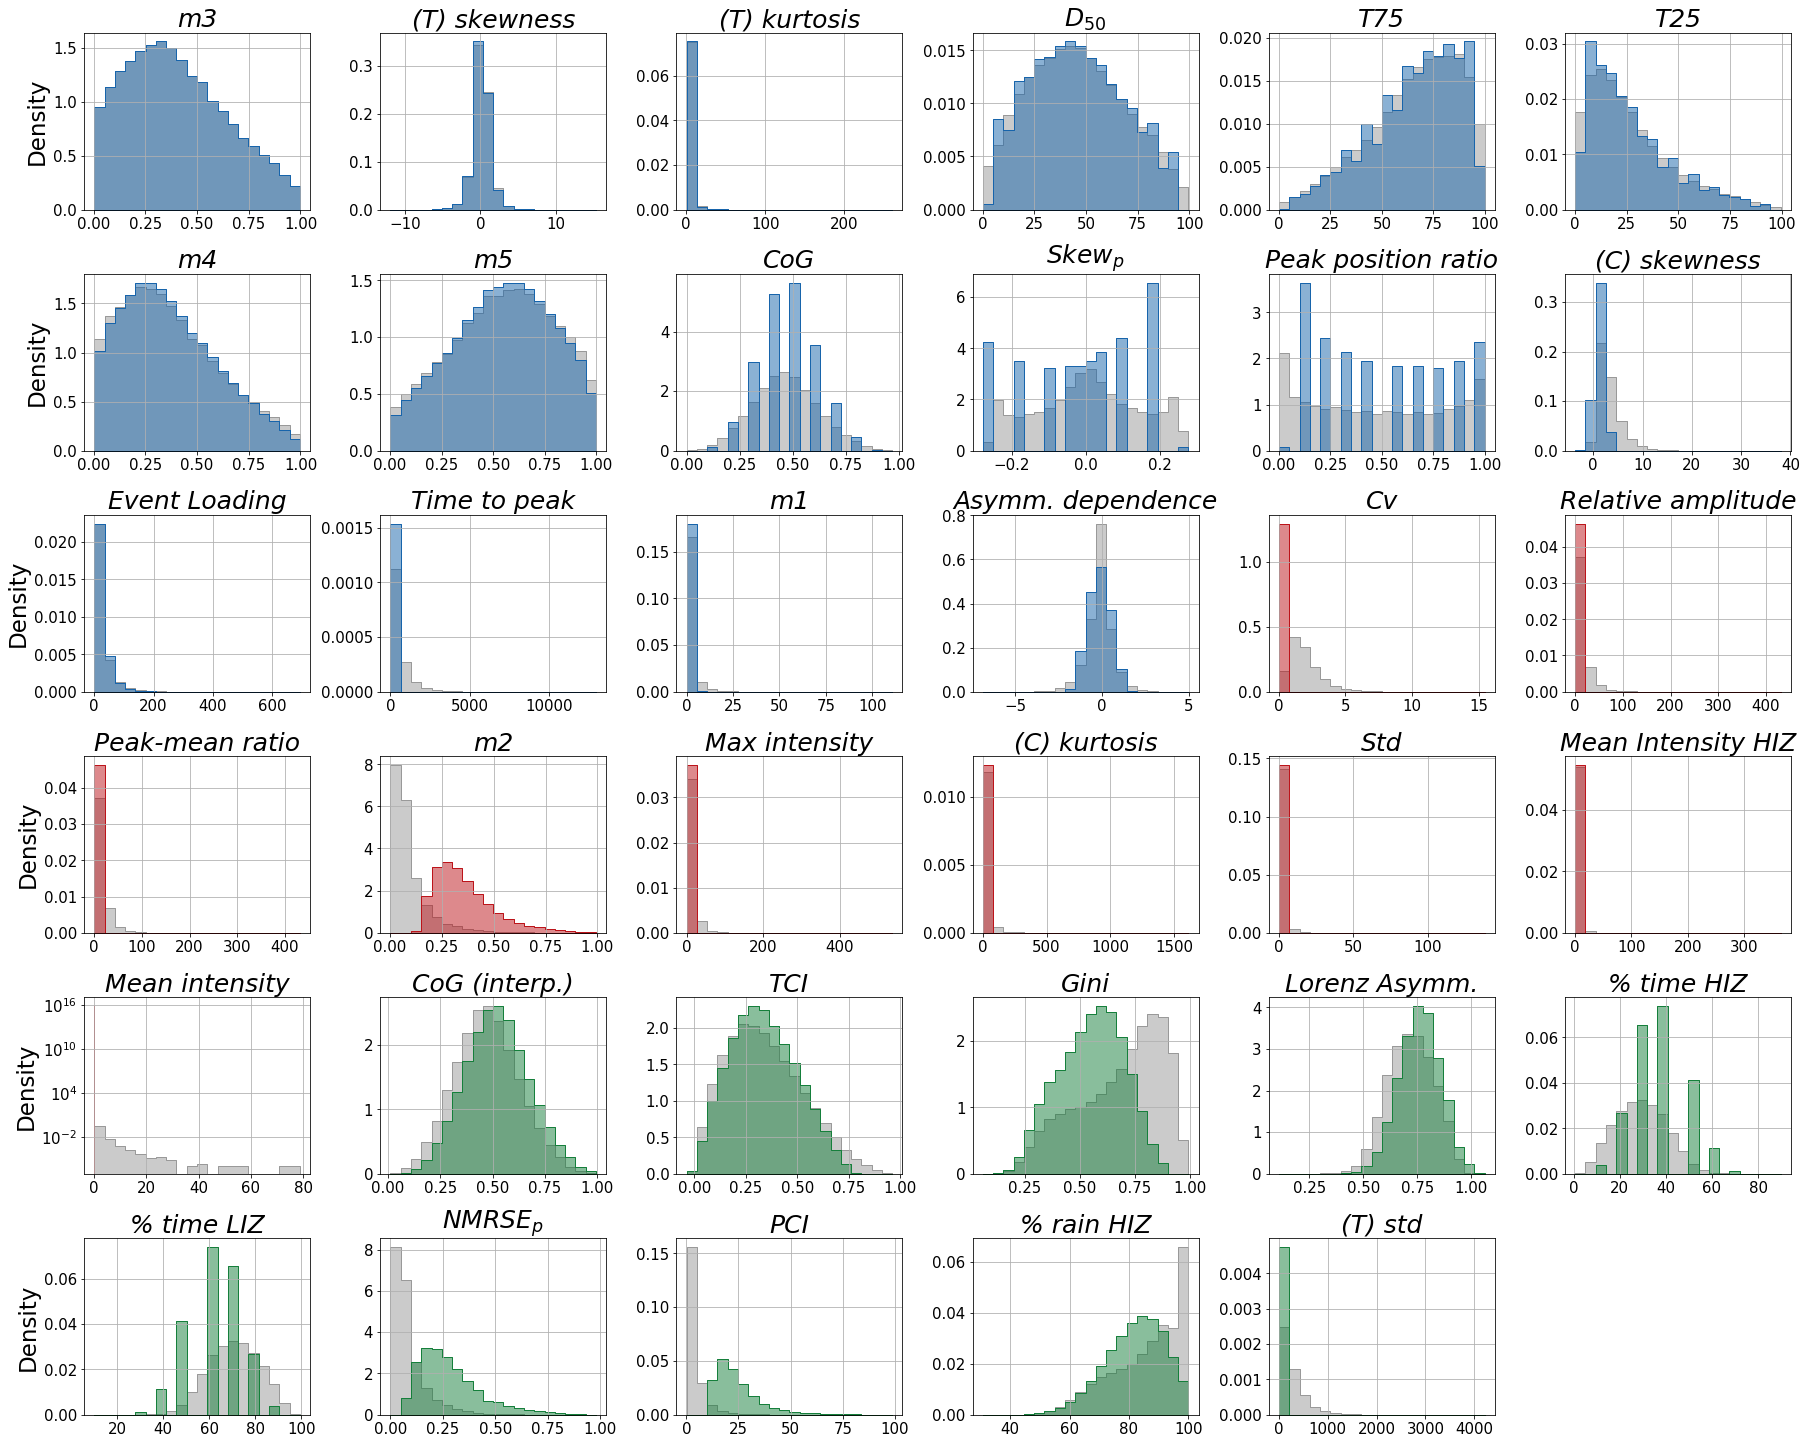

In [42]:
log_scale_metrics = ['mean_intensity', 'time_to_peak', 'std', 'Mean Intensity HIZ', 'm1', 'm1_wi', 'cv', 'time_kurtosis',
                    'max_intensity', 'mean_intensity', 'kurtosis', 'relative_amp', 'peak_mean_ratio', 'Event Loading']

separate_bin_metrics = ['cv', 'm1', 'time_to_peak', "kurtosis", "max_intensity", "std", 'mean_intensity']


unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

# Track max/min values for autoscaled limits
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

for i, this_metric in enumerate(unique_metrics_main):
    if this_metric not in []:
        ax = axs_main[i]
        metric_data = df_other[df_other["metric"] == this_metric]
        plot_histograms(ax, this_metric, transformed_minmax_scaled, type_mapping, name_mapping, resolutions, log_scale_metrics)

#         # Update global x/y limits
#         x_vals = metric_data["rank_corr"]
#         y_vals = metric_data["val_diff"]
#         if not x_vals.empty and not y_vals.empty:
#             x_min = min(x_min, x_vals.min())
#             x_max = max(x_max, x_vals.max())
#             y_min = min(y_min, y_vals.min())
#             y_max = max(y_max, y_vals.max())

for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')
    
for i, ax in enumerate(axs_main):
    if i % n_cols_main == 0:  # First column in each row
        ax.set_ylabel('Density', fontsize=23)
    else:
        ax.set_ylabel('')        

# fig_main.suptitle("Summary statistics (Asymmetry, Peakiness, Concentration)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("../Figures/histograms_main_DMC10.png", dpi=300, facecolor='white')


# # --- PLOT 2: Intermittency Figure ---
# if not df_intermittency.empty:
#     unique_metrics_int = df_intermittency["metric"].unique()
#     n_cols_int = 6
#     n_rows_int = -(-len(unique_metrics_int) // n_cols_int)

#     fig_int, axs_int = plt.subplots(ncols=n_cols_int, nrows=n_rows_int,
#                                     figsize=(4.2 * n_cols_int, 4.5 * n_rows_int),
#                                     sharex=False, sharey=False)
#     axs_int = axs_int.flatten()

#     # Plot each metric
#     for i, this_metric in enumerate(unique_metrics_int):
#         ax = axs_int[i]
#         metric_data = df_intermittency[df_intermittency["metric"] == this_metric]
#         plot_histograms(ax, this_metric, transformed_minmax_scaled, type_mapping, resolutions, log_scale_metrics)

#     legend_types = list(type_color_map.keys())
#     legend_axes_start = len(unique_metrics_int)  # first free subplot
    
#     labels = ['5 minute raw', 'DMC']
    
#     for i, metric_type in enumerate(legend_types):
#         idx = legend_axes_start + i
#         if idx < len(axs_int):
#             ax_legend = axs_int[idx]
#             ax_legend.axis('off')
#             colors = type_color_map[metric_type]
#             patches = [Patch(facecolor=colors[j], label=labels[j], alpha=0.6) for j in range(len(resolutions))]
#             ax_legend.legend(handles=patches, title=metric_type, loc='center', frameon=False, ncol=1, handlelength=2,
#                              fontsize=25, title_fontsize =30)

#     # Turn off any remaining unused axes after legend
#     for ax in axs_int[legend_axes_start + len(legend_types):]:
#         ax.axis('off')
        
#     for i, ax in enumerate(axs_int):
#         if i % n_cols_int == 0:  # First column in each row
#             ax.set_ylabel('Density', fontsize=23)
#         else:
#             ax.set_ylabel('')
            
# #     fig_int.suptitle("Intermittency metrics", fontsize=25)
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

#     fig_int.savefig("../Figures/histograms_intermittency_DMC10.png", dpi=300, facecolor='white')

In [ ]:
# all_metric_names = filtered_df['metric'].unique()

# # --- Assign types ---
# metric_type_df = (
#     pd.DataFrame({'metric': all_metric_names})
#     .assign(type_2=lambda df: df['metric'].map(type_2_mapping)))

# metric_type_df.fillna('Categorical', inplace=True)

In [ ]:
# --- now make your grid of small multiples ---
unique_metrics =df_categorical['metric'].unique().tolist()
n_cols = 6
n_rows = -(-len(unique_metrics) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False, sharey=False)
axs = axs.flatten()

for i, metric in enumerate(unique_metrics):
    plot_grouped_categorical(
        axs[i],
        metric,
        transformed_minmax_scaled,
        metric_type_df,
        type_color_map
    )

# turn off any unused axes
for ax in axs[len(unique_metrics):]:
    ax.axis('off')

for i, ax in enumerate(axs):
    if i % n_cols == 0:  # First column in each row
        ax.set_ylabel('% of events', fontsize=26)
    else:
        ax.set_ylabel('')    

from matplotlib.patches import Patch

# Create custom legend handles using the palette
palette = type_color_map['Categorical']
labels = ['5 minute raw', 'DMC']
legend_handles = [
    Patch(facecolor=palette[i], edgecolor='white', label=labels[i], alpha=0.6)
    for i, res in enumerate(labels)]

fig.legend(
    handles=legend_handles,
    labels=labels,
    title="Categorical",
     frameon=False,
    title_fontsize=25,    # larger title
    fontsize=22,          # larger labels
    bbox_to_anchor=(0.53, 0.28),
    loc='center left',
    labelspacing=0.5,     # space between labels
    handlelength=2.7,     # length of color boxes
    handletextpad=0.8     # space between box and text
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig("../Figures/grouped_categorical_metrics_DMC10.png", dpi=300, facecolor='white')